In [3]:
import pathlib
import os
import math
import pandas as pd
import time
import json
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import logging
import seaborn as sns
import multiprocessing
from utils_and_constants import labels
import typing
import albumentations as A
from sklearn.model_selection import train_test_split

np.random.seed(314)
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
logging.basicConfig(level=logging.ERROR)

2025-02-14 10:37:33.236777: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-14 10:37:33.339781: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-14 10:37:33.419948: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739525853.500336   47660 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739525853.522146   47660 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-14 10:37:33.723700: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

# Présentation des données 

**====================  Dossier `Raw`  ====================**


Le jeu de données utilisé pour la conception du modèle de segmentation d'images est composé de deux répertoires:
- Un répertoire `gtFine` contenant les images de masques annotées (20 000 fichiers). Chaque image se distingue par 4 fichiers différents:
    - Un fichier `color` en couleurs (5 000 fichiers png)
    - Un fichier `instanceIds` en niveaux de gris (5 000 fichiers png)
    - Un fichier `labelIds` en niveaux de gris (5 000 fichiers png)
    - Un fichier `polygons` contenant les coordonnées des zones segmentéees (5 000 fichiers json)
- Un répertoire `leftImg8bit` contenant les images brutes en couleurs (5 000 fichiers)


Chacun de ces répertoires est ensuite subdivisé en trois sous répertoires, qui eux mêmes contiennent des sous-répertoires en fonction des villes:
- `train` contenant les données d'entraînement (2975 images)
- `val` contenant les données de validation  (500 images)
- `test` dont les annotations ne sont pas rendues publiques, donc inexploitables dans le cas présent (1525 images)


Pour plus d'informations sur le dataset, merci de lire le README suivant : https://github.com/mcordts/cityscapesScripts/blob/master/README.md

**====================  Dossier `Sorted`  ====================**


La première étape consiste à préparer les dossiers pour le jeu d'entraînement, de validation et de test dans ce nouveau dossier.<br>
Premièrement, on ignore les dossiers de test puisque nous n'avons pas accès aux annotations.<br>


Après ces étapes de préparation, le dossier `Sorted` contiendra les données suivantes:
- Un répertoire `train` contenant uniquement les fichiers d'images et de masques d'entraînement en niveaux de gris `labelIds` et en couleur `color` soit un total de 2975 * 3 = 8925 fichiers
- Un répertoire `test` contenant uniquement les fichiers d'images et de masques de validation du dossier `val` en niveaux de gris `labelIds` et en couleur `color` soit un total de 500 * 3 = 1500 fichiers


Commençons par vérifier que nous avons bien toutes les données après avoir exécutées les commandes bash dans le terminal:

In [2]:
TARGET_SIZE = (256, 512)
print("New Target Shape: ", TARGET_SIZE)
print("Number of CPU cores available: ", NUM_WORKERS := os.cpu_count())


New Target Shape:  (256, 512)
Number of CPU cores available:  16


In [26]:
class Dataloaderv10(tf.keras.utils.PyDataset):
    def __init__(
        self,
        paths: typing.List[pathlib.Path],
        labels: typing.NamedTuple,
        batch_size: int,
        target_size: typing.Tuple[int, int],
        augmentations: False,
        preview: int = None,  # Load only a subset of the dataset for preview.
        normalize: bool = True,
        shuffle: bool = True,
        label_onehot: bool = False,
        threadpool: bool = False,
        **kwargs,
    ):
        """
        Initialize the Dataloaderv9 data generator.
        """
        super().__init__(**kwargs)

        # Logger initialization
        self.logger = self._setup_logger()

        # Set class attributes initialized with constructor arguments
        self.paths = paths
        self.labels = labels
        self.batch_size = batch_size
        self.target_size = target_size
        self.augmentations = augmentations
        self.normalize = normalize
        self.shuffle = shuffle
        self.label_onehot = label_onehot
        self.threadpool = threadpool  # If True, use multiprocessing.Pool

        # Initialize the augmentation pipeline
        if self.augmentations:
            self.compose = A.Compose(
                [
                    A.HorizontalFlip(p=0.9),
                    A.RandomBrightnessContrast(
                        p=0.2, brightness_limit=0.2, contrast_limit=0.2
                    ),
                    A.Blur(p=0.2, blur_limit=3),
                    A.HueSaturationValue(p=0.2, hue_shift_limit=20, sat_shift_limit=30),
                ]
            )

        # Get image and mask file paths using pathlib
        self.image_paths, self.mask_paths = self._load_paths(preview)
        self._validate_paths()

        # Attributes initialized from labels elements
        self.table_id2category = {label.id: label.categoryId for label in self.labels}
        self.num_classes = len(set(self.table_id2category.values()))
        # Disable PIL logging DEBUG
        logging.getLogger("PIL").setLevel(logging.WARNING)

        # Shuffle the dataset before starting
        if self.shuffle:
            self.on_epoch_end()

    # Initialize logger
    def _setup_logger(self):
        logger = logging.getLogger("dataloader")
        logger.setLevel(logging.ERROR)
        return logger

    # Load image and mask paths and apply preview if requested to slice the dataset
    def _load_paths(self, preview: int):
        # Get image and mask file paths using pathlib
        image_paths, mask_paths = zip(*self.paths)

        # Apply preview if requested
        if preview is not None:
            image_paths = image_paths[:preview]
            mask_paths = mask_paths[:preview]

        return image_paths, mask_paths

    # Validate that the number of images and masks are equal before starting
    def _validate_paths(self):
        if len(self.image_paths) != len(self.mask_paths):
            self.logger.error(
                "Number of images (%d) and masks (%d) must be equal.",
                len(self.image_paths),
                len(self.mask_paths),
            )
            raise ValueError("Number of images and masks must be equal.")

    # Return the number of samples in the dataset using dynamic property
    @property
    def num_samples(self):
        return len(self.image_paths)

    # Class method to return the number of batches in the dataset using len()
    def __len__(self) -> int:
        length = math.ceil(self.num_samples / self.batch_size)
        self.logger.debug(f"Number of batches: {length}")
        return length

    # Class method to fetch a batch of images and masks with the given index
    def __getitem__(self, index: int):
        # Calculate start and end indices for the batch
        start_idx = index * self.batch_size
        end_idx = min(start_idx + self.batch_size, self.num_samples)
        if start_idx >= self.num_samples:
            raise IndexError("Index out of range")

        # Prépare les paires (image_path, mask_path) du batch
        batch_paths = list(
            zip(
                self.image_paths[start_idx:end_idx],
                self.mask_paths[start_idx:end_idx],
            )
        )

        # Log the batch fetching
        self.logger.debug(
            f"Fetching batch {index}: start_idx={start_idx}, end_idx={end_idx}"
        )

        # Load images and masks using multiprocessing if threadpool is True
        if self.threadpool:
            self.use_multiprocessing = False
            with multiprocessing.Pool() as pool:
                results = pool.map(self.load_and_augment, batch_paths)
        # Load images and masks using list comprehension if threadpool is False
        else:
            results = [self.load_and_augment(pair) for pair in batch_paths]

        # Return batch images and masks as numpy arrays
        batch_images, batch_masks = zip(*results)
        return np.asarray(batch_images), np.asarray(batch_masks)

    # Shuffle the dataset before starting a new epoch
    def on_epoch_end(self):
        if self.shuffle:
            zip_paths = list(zip(self.image_paths, self.mask_paths))
            np.random.shuffle(zip_paths)
            self.image_paths, self.mask_paths = zip(*zip_paths)
        else:
            pass

    # Normalize the image array if normalize is True
    def _normalize_img(self, img_array):
        return img_array / 255.0

        # Transform mask to categorical one-hot encoding

    def _transform_mask_to_categorical(self, mask):
        return tf.keras.utils.to_categorical(mask, num_classes=self.num_classes)

    # Load image to array and normalize if normalize is True
    def load_img_to_array(self, img_path: pathlib.Path):
        img = tf.keras.utils.load_img(
            str(img_path),
            target_size=self.target_size,
            color_mode="rgb",
            interpolation="bilinear",
        )
        img_array = tf.keras.utils.img_to_array(img, dtype=np.float32)
        if self.normalize:
            img_array = self._normalize_img(img_array)
        return img_array

    # Load mask to array and map mask ids to categories
    def load_mask_to_array(self, mask_path: pathlib.Path):
        mask = tf.keras.utils.load_img(
            str(mask_path),
            target_size=self.target_size,
            color_mode="grayscale",
            interpolation="nearest",
        )
        mask_array = tf.keras.utils.img_to_array(mask, dtype=np.int8)
        # Map mask ids to categories
        mapped = (np.vectorize(self.table_id2category.get)(mask_array)).squeeze()
        if self.label_onehot:
            mapped = self._transform_mask_to_categorical(mapped)
        return mapped

    def load_and_augment(self, paths):
        img, mask = paths
        img = self.load_img_to_array(img)
        mask = self.load_mask_to_array(mask)
        if self.augmentations:
            augmented = self.compose(image=img, mask=mask)
            return augmented["image"], augmented["mask"]
        else:
            return img, mask

    # Return an image and mask pair for visualization with the path
    def get_image_mask_and_paths(self, index: int):
        paths = self.image_paths[index], self.mask_paths[index]
        img, mask = self.load_and_augment(paths)
        return img, mask, *paths

In [27]:
# Path to the root directory
root_dir = pathlib.Path.cwd().parent
# Path to the train directory
train_dir = root_dir / "data" / "Sorted" / "train"
# Path to the test directory
test_dir = root_dir / "data" / "Sorted" / "test"
# Print the number of files after sorting the files
print("Train files: ", len(os.listdir(train_dir)))
print("Test files: ", len(os.listdir(test_dir)))

Train files:  8925
Test files:  1500


In [28]:
image_paths = sorted(list(train_dir.glob("*leftImg8bit.png")))
mask_paths = sorted(list(train_dir.glob("*labelIds.png")))
image_train, image_val, mask_train, mask_val = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=314
)
train_paths = list(zip(image_train, mask_train))
val_paths = list(zip(image_val, mask_val))

In [29]:
image_paths = sorted(list(test_dir.glob("*leftImg8bit.png")))
mask_paths = sorted(list(test_dir.glob("*labelIds.png")))
test_paths = list(zip(image_paths, mask_paths))

In [234]:
%%timeit -r 5 -n 1
datagen = Dataloaderv10(
    train_paths,
    labels,
    batch_size=64,
    target_size=TARGET_SIZE,
    workers=NUM_WORKERS,
    preview=128,
    threadpool=True,
    augmentations=True,
    shuffle=True,
    label_onehot=True,
    use_multiprocessing=False,
    normalize=True,
)
for batch_images, batch_masks in datagen:
    print(batch_images.shape, batch_masks.shape)
    print(batch_images[0].shape, batch_masks[0].shape)

DEBUG:dataloader:Fetching batch 0: start_idx=0, end_idx=64


DEBUG:dataloader:Fetching batch 1: start_idx=64, end_idx=128


(64, 256, 512, 3) (64, 256, 512, 8)
(256, 512, 3) (256, 512, 8)


DEBUG:dataloader:Fetching batch 0: start_idx=0, end_idx=64


(64, 256, 512, 3) (64, 256, 512, 8)
(256, 512, 3) (256, 512, 8)


DEBUG:dataloader:Fetching batch 1: start_idx=64, end_idx=128


(64, 256, 512, 3) (64, 256, 512, 8)
(256, 512, 3) (256, 512, 8)


DEBUG:dataloader:Fetching batch 0: start_idx=0, end_idx=64


(64, 256, 512, 3) (64, 256, 512, 8)
(256, 512, 3) (256, 512, 8)


DEBUG:dataloader:Fetching batch 1: start_idx=64, end_idx=128


(64, 256, 512, 3) (64, 256, 512, 8)
(256, 512, 3) (256, 512, 8)


DEBUG:dataloader:Fetching batch 0: start_idx=0, end_idx=64


(64, 256, 512, 3) (64, 256, 512, 8)
(256, 512, 3) (256, 512, 8)


DEBUG:dataloader:Fetching batch 1: start_idx=64, end_idx=128


(64, 256, 512, 3) (64, 256, 512, 8)
(256, 512, 3) (256, 512, 8)


DEBUG:dataloader:Fetching batch 0: start_idx=0, end_idx=64


(64, 256, 512, 3) (64, 256, 512, 8)
(256, 512, 3) (256, 512, 8)


DEBUG:dataloader:Fetching batch 1: start_idx=64, end_idx=128


(64, 256, 512, 3) (64, 256, 512, 8)
(256, 512, 3) (256, 512, 8)
(64, 256, 512, 3) (64, 256, 512, 8)
(256, 512, 3) (256, 512, 8)
5.93 s ± 624 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


- 1.93 (v9)
- 2.4 (v9_)

# Model

In [7]:
def encoder_block(inputs, num_filters):
    # Convolution with 3x3 filter followed by ReLU activation
    x = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(inputs)
    x = tf.keras.layers.Activation("relu")(x)

    # Convolution with 3x3 filter followed by ReLU activation
    x = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(x)
    x = tf.keras.layers.Activation("relu")(x)

    # Max Pooling with 2x2 filter
    x = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2)(x)

    return x


In [8]:
def decoder_block(inputs, skip_features, num_filters):
    # Upsampling with 2x2 filter
    x = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(
        inputs
    )

    # Copy and crop the skip features
    # to match the shape of the upsampled input
    skip_features = ResizeSkipFeatures()([x, skip_features])
    x = tf.keras.layers.Concatenate()([x, skip_features])

    # Convolution with 3x3 filter followed by ReLU activation
    x = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(x)
    x = tf.keras.layers.Activation("relu")(x)

    # Convolution with 3x3 filter followed by ReLU activation
    x = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(x)
    x = tf.keras.layers.Activation("relu")(x)

    return x


In [9]:
class ResizeSkipFeatures(tf.keras.layers.Layer):
    def call(self, inputs):
        x, skip_features = inputs
        return tf.image.resize(skip_features, size=(tf.shape(x)[1], tf.shape(x)[2]))

In [10]:
def unet_model(input_shape=(256, 512, 3), num_classes=8, name="u-net"):
    inputs = tf.keras.layers.Input(input_shape)

    # Contracting Path
    s1 = encoder_block(inputs, 64)
    s2 = encoder_block(s1, 128)
    s3 = encoder_block(s2, 256)
    s4 = encoder_block(s3, 512)

    # Bottleneck
    b1 = tf.keras.layers.Conv2D(1024, 3, padding="same")(s4)
    b1 = tf.keras.layers.Activation("relu")(b1)
    b1 = tf.keras.layers.Conv2D(1024, 3, padding="same")(b1)
    b1 = tf.keras.layers.Activation("relu")(b1)

    # Expansive Path
    s5 = decoder_block(b1, s4, 512)
    s6 = decoder_block(s5, s3, 256)
    s7 = decoder_block(s6, s2, 128)
    s8 = decoder_block(s7, s1, 64)

    # Output
    outputs = tf.keras.layers.Conv2D(
        num_classes, 1, padding="same", activation="softmax"
    )(s8)

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name="U-Net")
    return model


In [11]:
model = unet_model()
model.summary()

2025-02-14 07:31:55.692180: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 512,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 512,  │          0 │ conv2d[0][0]      │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 512,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 512,  │          0 │ conv2d_1[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 256,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 256,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 256,  │          0 │ conv2d_2[0][0]    │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 256,  │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 256,  │          0 │ conv2d_3[0][0]    │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 128,   │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 128,   │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 64, 128,   │          0 │ conv2d_4[0][0]    │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 128,   │    590,080 │ activation_4[0][… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 64, 128,   │          0 │ conv2d_5[0][0]    │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 64,    │          0 │ activation_5[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 64,    │  1,180,160 │ max_pooling2d_2[

 Total params: 31,032,200 (118.38 MB)

 Trainable params: 31,032,200 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

Exemple de calcul de métrique ou y_true et y_pred sont des tensors de shape (batch_size, height, width, num_classes) , ce qui n'dest pas notre cas (à adapter avec y_true en sparse)

In [12]:
class DiceMetric(tf.keras.metrics.Metric):
    def __init__(self, num_classes, smooth=1e-5, name="dice_metric", **kwargs):
        super().__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.smooth = smooth
        self.total_dice = self.add_weight(name="total_dice", initializer="zeros")
        self.count = self.add_weight(name="count", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert the sparse y_true to one-hot encoding
        y_true_onehot = tf.one_hot(
            y_true, depth=self.num_classes
        )  # (batch, h, w, num_classes)

        # Convert the y_pred probabilities with argmax
        y_pred_indices = tf.argmax(y_pred, axis=-1)  # (batch, h, w)
        # Convert the y_pred indices to one-hot encoding
        y_pred_onehot = tf.one_hot(
            y_pred_indices, depth=self.num_classes
        )  # (batch, h, w, num_classes)

        # Flatten the one-hot tensors on all axes except batch
        y_true_flat = tf.reshape(
            y_true_onehot, [tf.shape(y_true_onehot)[0], -1, self.num_classes]
        )  # (batch, h*w, num_classes)
        y_pred_flat = tf.reshape(
            y_pred_onehot, [tf.shape(y_pred_onehot)[0], -1, self.num_classes]
        )  # (batch, h*w, num_classes)

        # Compute intersection and union for each class
        intersection = tf.reduce_sum(
            y_true_flat * y_pred_flat, axis=1
        )  # (batch, num_classes)
        union = tf.reduce_sum(y_true_flat, axis=1) + tf.reduce_sum(
            y_pred_flat, axis=1
        )  # (batch, num_classes)

        # Compute DICE score for each class with the smoothening factor
        dice = (2.0 * intersection + self.smooth) / (union + self.smooth)

        # Compute the DICE mean score for each image
        dice_per_image = tf.reduce_mean(dice, axis=-1)  # (batch,)

        # Update the total dice and count with the mean dice score per image
        self.total_dice.assign_add(tf.reduce_sum(dice_per_image))
        self.count.assign_add(tf.cast(tf.size(dice_per_image), tf.float32))

    def result(self):
        # Compute the mean dice score over all images
        return self.total_dice / self.count

    def reset_states(self):
        # Reset the total dice and count at the end of each epoch
        self.total_dice.assign(0.0)
        self.count.assign(0.0)

In [13]:
mean_metrics = [
    tf.keras.metrics.MeanIoU(
        num_classes=8,
        name="MeanIoU",
        dtype=None,
        ignore_class=None,  # Add Void if necessary
        sparse_y_true=True,  # As we are using sparse categorical crossentropy, the ground truth is sparse
        sparse_y_pred=False,  # As we are using softmax activation, the output is not sparse
        axis=-1,
    ),
    DiceMetric(num_classes=8, name="Dice"),
    tf.keras.metrics.SparseCategoricalAccuracy(name="Pixel_Accuracy"),
]

In [14]:
per_class_metrics = [
    tf.keras.metrics.IoU(
        num_classes=8,
        target_class_ids=[i],  # Compute the IoU for the background class (class 0)
        name=f"IoU_class_{i}",
        sparse_y_true=True,
        sparse_y_pred=False,
        axis=-1,
    )
    for i in range(8)
]

In [15]:
scores = []
for i in range(3):
    m = tf.keras.metrics.IoU(
        num_classes=3, target_class_ids=[i], sparse_y_pred=True, sparse_y_true=True
    )
    m.update_state(
        [1, 2, 2, 1, 2, 2],  # y_true
        [1, 1, 2, 2, 2, 1],  # y_pred
        # sample_weight=None or can be [1, 1, 1, 1, 1, 1]
    )
    print(f"IoU class {i} = {m.result().numpy()}")
    scores.append(m.result().numpy())
print(
    f"Mean IoU is biased here because we took into account IoU Class 0 = {np.mean(scores)}"
)

IoU class 0 = 0.0
IoU class 1 = 0.2499999701976776
IoU class 2 = 0.3999999463558197
Mean IoU is biased here because we took into account IoU Class 0 = 0.21666663885116577


In [16]:
m = tf.keras.metrics.MeanIoU(num_classes=3, sparse_y_pred=True, sparse_y_true=True)
m.update_state(
    [1, 2, 2, 1, 2, 2],  # y_true
    [1, 1, 2, 2, 2, 1],  # y_pred
)
print(f"Mean IoU is not biased here = {m.result().numpy()}")

Mean IoU is not biased here = 0.32499998807907104


Le résultat de MeanIoU ne tient pas de la classe "Absente" pour renvoyer la moyenne.

In [30]:
train_datagen = Dataloaderv10(
    train_paths,
    labels,
    batch_size=16,
    target_size=TARGET_SIZE,
    augmentations=False,
    workers=NUM_WORKERS,
    preview=256,
    shuffle=True,
)
val_datagen = Dataloaderv10(
    val_paths,
    labels,
    batch_size=16,
    target_size=TARGET_SIZE,
    augmentations=False,
    workers=NUM_WORKERS,
    preview=64,
    shuffle=False,
)
test_datagen = Dataloaderv10(
    test_paths,
    labels,
    batch_size=16,
    target_size=TARGET_SIZE,
    augmentations=False,
    workers=NUM_WORKERS,
    preview=64,
    shuffle=False,
)

In [ ]:
folders = [int(f) for f in os.listdir("../artifacts")]
new_folder = max(folders) + 1 if folders else 0

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=f"../artifacts/{new_folder}/{model.name}_best_model.h5",  # chemin vers le fichier de sauvegarde
    monitor="val_loss",  # surveille la loss > MeanIoU
    mode="min",  # on veut minimiser la loss
    save_best_only=True,  # sauvegarde uniquement le meilleur modèle
    verbose=1,
)

# Create an early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",  # surveille la loss > MeanIoU
    patience=2,  # nombre d'époques sans amélioration avant de s'arrêter
    mode="min",  # on veut minimiser la loss
    verbose=1,
)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False,  # Set to False if y_pred is a probability distribution
    name="sparse_categorical_crossentropy",
)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

model.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=mean_metrics + per_class_metrics,
    # weighted_metrics=None,
    # steps_per_execution=1,
    # loss_weights=None,
)

history = model.fit(
    train_datagen,
    validation_data=val_datagen,
    epochs=15,
    callbacks=[checkpoint_callback, early_stopping],
)

Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - Dice: 0.0809 - IoU_class_0: 2.9475e-04 - IoU_class_1: 0.1618 - IoU_class_2: 0.1912 - IoU_class_3: 0.0000e+00 - IoU_class_4: 0.0000e+00 - IoU_class_5: 0.0339 - IoU_class_6: 0.0000e+00 - IoU_class_7: 0.0000e+00 - MeanIoU: 0.0484 - Pixel_Accuracy: 0.2442 - loss: 2.0456 
Epoch 1: val_loss improved from inf to 1.77362, saving model to ../artifacts/2/U-Net_best_model.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 389s 24s/step - Dice: 0.0825 - IoU_class_0: 2.8306e-04 - IoU_class_1: 0.1684 - IoU_class_2: 0.1908 - IoU_class_3: 0.0000e+00 - IoU_class_4: 0.0000e+00 - IoU_class_5: 0.0334 - IoU_class_6: 0.0000e+00 - IoU_class_7: 0.0000e+00 - MeanIoU: 0.0491 - Pixel_Accuracy: 0.2474 - loss: 2.0431 - val_Dice: 0.1452 - val_IoU_class_0: 0.0000e+00 - val_IoU_class_1: 0.2858 - val_IoU_class_2: 0.1905 - val_IoU_class_3: 0.0000e+00 - val_IoU_class_4: 0.0000e+00 - val_IoU_class_5: 0.0000e+00 - val_IoU_class_6: 0.0000e+00 - val_IoU_class_7: 0.0000e+00 - val_MeanIoU: 0.059

callbacks_list = [
                              tf.keras.callbacks.ReduceLROnPlateau(monitor='val_f1_score', factor=0.9, 
                                    patience=learning_rate_epochs, 
                                    verbose=0, mode='max', min_lr=0.0000001),
                  tf.keras.callbacks.ModelCheckpoint(filepath=fn, save_weights_only=True,
                                  monitor='val_f1_score',mode='max', save_best_only=True)]

In [ ]:
# Make the predictions
start_time = time.time()
preds = model.predict(test_datagen)
end_time = time.time()
inference_time = end_time - start_time
print(f"Inference time: {end_time - start_time:.2f} seconds")

4/4 ━━━━━━━━━━━━━━━━━━━━ 22s 5s/step
Inference time: 24.04 seconds


In [48]:
img, mask, img_path, mask_path = test_datagen.get_image_mask_and_paths(7)
exemple_preds = model.predict(tf.expand_dims(img, axis=0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


In [49]:
exemple_preds.shape

(1, 256, 512, 8)

In [50]:
preds_mask = np.argmax(exemple_preds.squeeze(), axis=-1)
preds_mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 5, 5, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [51]:
np.unique(preds_mask, return_counts=True)

(array([0, 1, 2, 4, 5, 6, 7]),
 array([ 9275, 54036, 19193, 15723, 12745,     1, 20099]))

In [34]:
params = {
    "epochs": len(history.epoch),
    "model_name": model.name,
    "classes": train_datagen.num_classes,
    "train_samples": train_datagen.num_samples,
    "val_samples": val_datagen.num_samples,
    "test_samples": test_datagen.num_samples,
    "train_batches": len(train_datagen),
    "augmentations": train_datagen.augmentations,
    "normalize": train_datagen.normalize,
    "loss_fn": loss_fn.name,
    "optimizer": optimizer.__class__.__name__,
    "learning_rate": float(optimizer.learning_rate.value.numpy()),
}

In [7]:
history = pd.read_json("../artifacts/2/U-Net_history.json")

In [23]:
len(history.iloc[0, 0])

15

In [31]:
series.to_list()

[[0.10863300412893201,
  0.11353216320276201,
  0.108478493988513,
  0.157216101884841,
  0.196918547153472,
  0.21498464047908702,
  0.270807474851608,
  0.308553457260131,
  0.333810776472091,
  0.40106129646301203,
  0.409888088703155,
  0.44275191426277105,
  0.44448429346084506,
  0.442100644111633,
  0.45439702272415106],
 [9.604640217730777e-05,
  0.0,
  0.0017360363854090001,
  0.032818797975778004,
  0.046507816761732004,
  0.09966427832841801,
  0.356383651494979,
  0.44707274436950606,
  0.43564295768737704,
  0.43682491779327304,
  0.45322224497795105,
  0.47161075472831704,
  0.45941630005836404,
  0.46215873956680303,
  0.492033064365386],
 [0.274401187896728,
  0.376564234495162,
  0.391021221876144,
  0.452363193035125,
  0.5321168303489681,
  0.562138378620147,
  0.6667317748069761,
  0.7221351265907281,
  0.7735012769699091,
  0.7716932296752931,
  0.783976018428802,
  0.79616093635559,
  0.807083904743194,
  0.8108910918235771,
  0.8176720142364501],
 [0.183637335896

In [35]:
history_metrics = pd.DataFrame(
    data=history.history[:24].to_list(),
    columns=[f"epoch_{i + 1}" for i in range(len(history.iloc[0, 0]))],
    index=history.history[:24].index,
)

<Axes: >

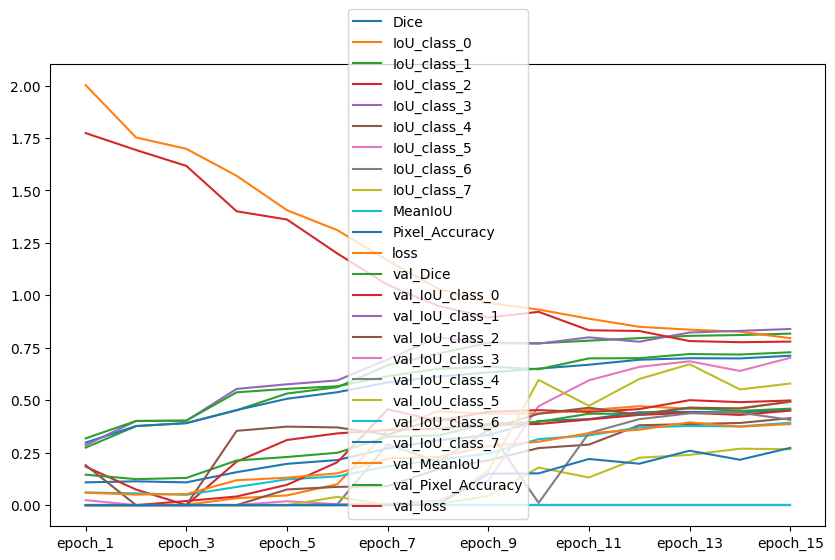

In [ ]:
history_metrics.T.plot(figsize=(10, 6))

In [45]:
history_metrics.T.columns

Index(['Dice', 'IoU_class_0', 'IoU_class_1', 'IoU_class_2', 'IoU_class_3',
       'IoU_class_4', 'IoU_class_5', 'IoU_class_6', 'IoU_class_7', 'MeanIoU',
       'Pixel_Accuracy', 'loss', 'val_Dice', 'val_IoU_class_0',
       'val_IoU_class_1', 'val_IoU_class_2', 'val_IoU_class_3',
       'val_IoU_class_4', 'val_IoU_class_5', 'val_IoU_class_6',
       'val_IoU_class_7', 'val_MeanIoU', 'val_Pixel_Accuracy', 'val_loss'],
      dtype='object')

In [47]:
[col for col in history_metrics.T.columns if col.startswith("val_")]

['val_Dice',
 'val_IoU_class_0',
 'val_IoU_class_1',
 'val_IoU_class_2',
 'val_IoU_class_3',
 'val_IoU_class_4',
 'val_IoU_class_5',
 'val_IoU_class_6',
 'val_IoU_class_7',
 'val_MeanIoU',
 'val_Pixel_Accuracy',
 'val_loss']

<Axes: >

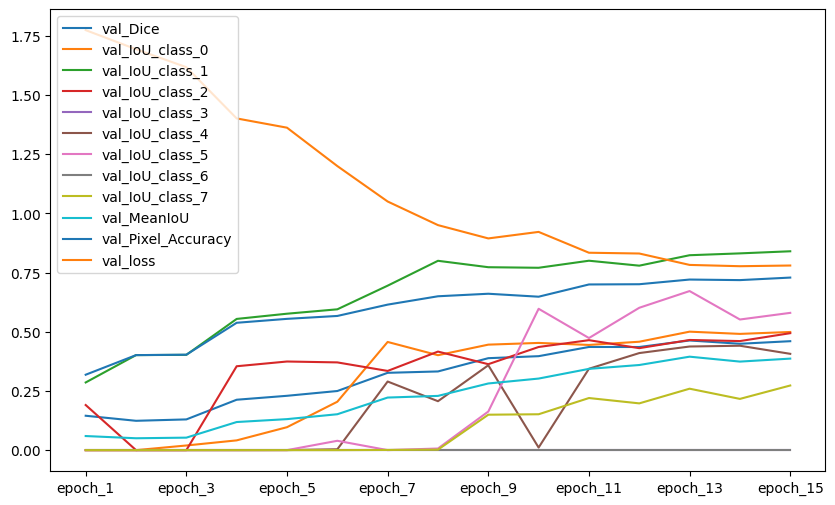

In [48]:
history_metrics.T.filter(
    [col for col in history_metrics.T.columns if col.startswith("val_")]
).plot(figsize=(10, 6))

<Axes: >

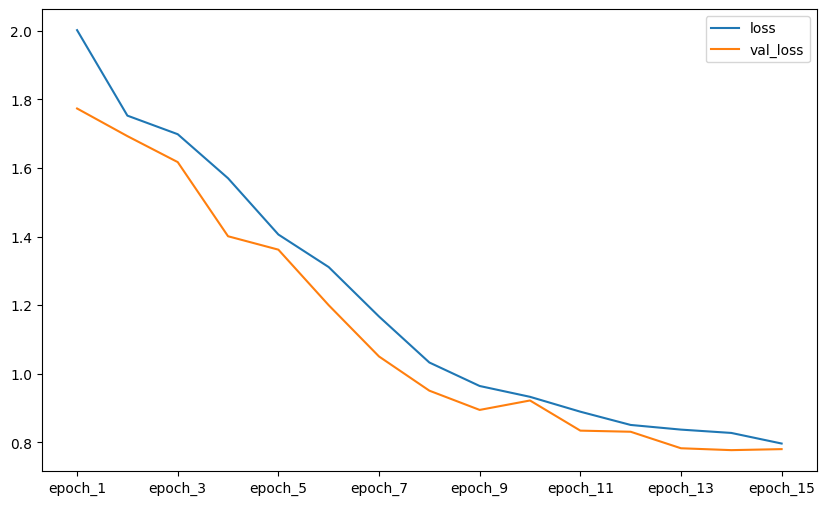

In [ ]:
# Mask Loss
loss_mask = [col for col in history_metrics.T.columns if "loss" in col]
history_metrics.T.filter(
    loss_mask
).plot(figsize=(10, 6))

<Axes: >

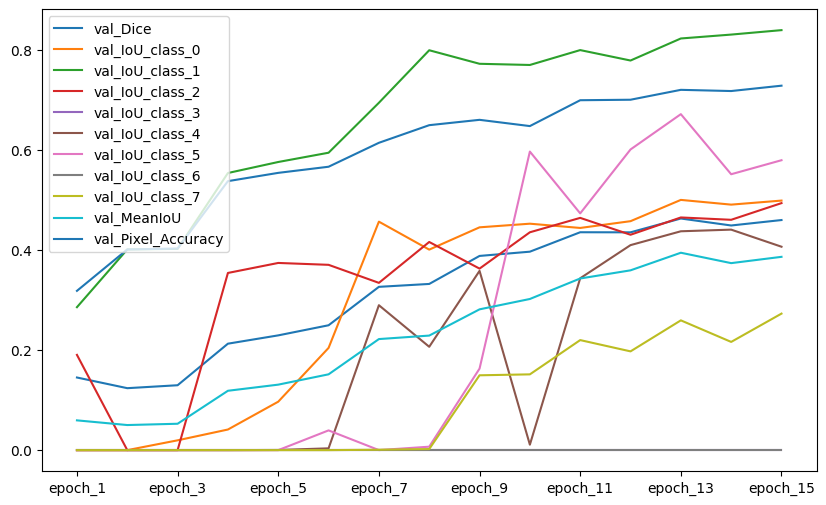

In [53]:
history_metrics.T.filter(
    [
        col
        for col in history_metrics.T.columns
        if col.startswith("val_") and "loss" not in col
    ]
).plot(figsize=(10, 6))

<Axes: >

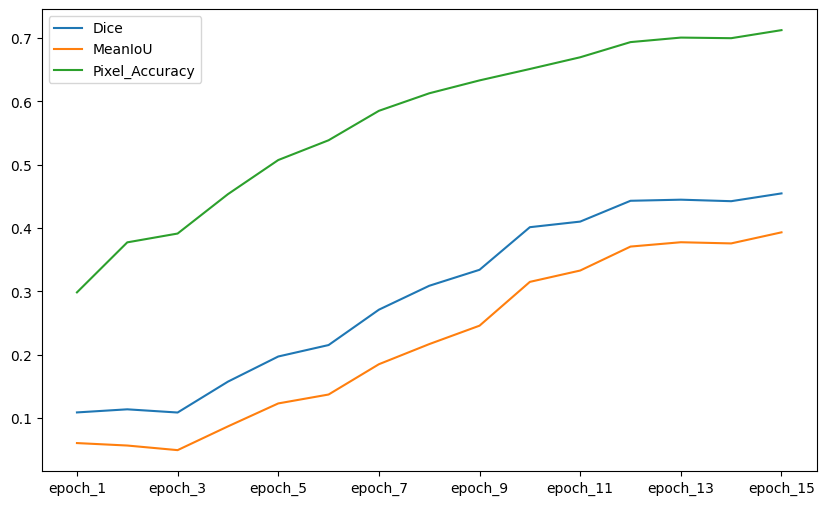

In [55]:
history_metrics.T.filter(
    [
        col
        for col in history_metrics.T.columns
        if not col.startswith("val_")
        and "loss" not in col
        and not col.startswith("IoU")
    ]
).plot(figsize=(10, 6))

<Axes: >

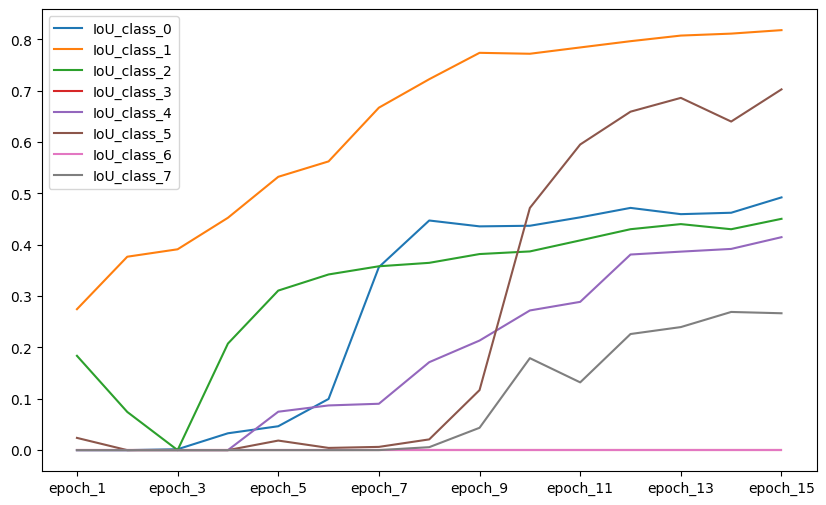

In [56]:
history_metrics.T.filter(
    [
        col
        for col in history_metrics.T.columns
        if not col.startswith("val_") and "loss" not in col and col.startswith("IoU")
    ]
).plot(figsize=(10, 6))

In [37]:
# Take the epoch with the best validation loss
best_val_loss = history.history["val_loss"].index(min(history.history["val_loss"]))

In [38]:
# Dump the metrics and params to a JSON file
with open(f"../artifacts/{new_folder}/{model.name}_history.json", "w") as f:
    json.dump(
        {
            "history": history.history,
            "model_config": model.get_config(),
            "params": params,
            "inference_time": inference_time,
        },
        f,
    )

In [5]:
pd.read_json(f"../artifacts/{new_folder}/{model.name}_history.json")

NameError: name 'new_folder' is not defined

In [39]:
pd.DataFrame(history.history).iloc[best_val_loss, :].to_frame().T

,Dice,IoU_class_0,IoU_class_1,IoU_class_2,IoU_class_3,IoU_class_4,IoU_class_5,IoU_class_6,IoU_class_7,MeanIoU,...,val_IoU_class_1,val_IoU_class_2,val_IoU_class_3,val_IoU_class_4,val_IoU_class_5,val_IoU_class_6,val_IoU_class_7,val_MeanIoU,val_Pixel_Accuracy,val_loss
13,0.442101,0.462159,0.810891,0.430071,0.0,0.391739,0.639716,0.0,0.269015,0.375449,...,0.830877,0.460552,0.0,0.44089,0.551649,0.0,0.216368,0.373903,0.718001,0.776703


In [40]:
metrics_filepath = "../metrics.csv"
# Take the epoch with the best validation loss
best_epoch = history.history["val_loss"].index(min(history.history["val_loss"]))
# Append the metrics to the metrics.csv file containing best epoch metrics, model name, and inference time and params
metrics_df = pd.DataFrame(history.history).iloc[best_val_loss, :].to_frame().T
metrics_df["best_epoch"] = best_epoch
metrics_df["n_epochs"] = params["epochs"]
metrics_df["model_name"] = model.name
metrics_df["inference_time"] = inference_time
metrics_df.insert(0, "experiment_folder", new_folder)
for key, value in params.items():
    metrics_df[key] = value
if not os.path.exists(metrics_filepath):
    metrics_df.to_csv(metrics_filepath, mode="a", header=True, index=False)
else:
    metrics_df.to_csv(metrics_filepath, mode="a", header=False, index=False)

In [41]:
pd.read_csv(metrics_filepath).drop_duplicates()

,experiment_folder,Dice,IoU_class_0,IoU_class_1,IoU_class_2,IoU_class_3,IoU_class_4,IoU_class_5,IoU_class_6,IoU_class_7,...,classes,train_samples,val_samples,test_samples,train_batches,augmentations,normalize,loss_fn,optimizer,learning_rate
0,0,0.113098,0.000000,0.366003,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,8,32,16,32,8,False,True,sparse_categorical_crossentropy,Adam,0.0001
1,2,0.442101,0.462159,0.810891,0.430071,0.0,0.391739,0.639716,0.0,0.269015,...,8,256,64,64,16,False,True,sparse_categorical_crossentropy,Adam,0.0001


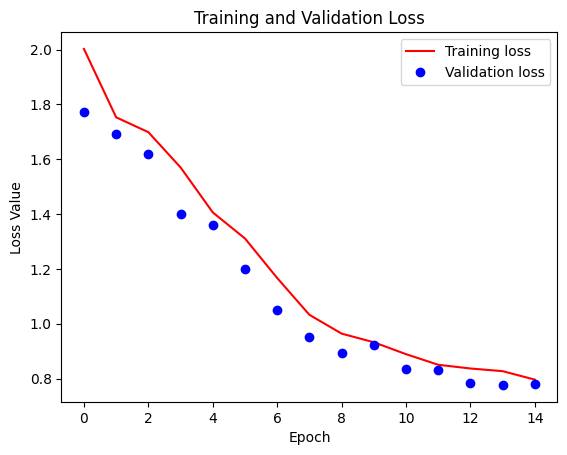

In [ ]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.figure()
plt.plot(history.epoch, loss, "r", label="Training loss")
plt.plot(history.epoch, val_loss, "bo", label="Validation loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss Value")
plt.legend()
plt.show()

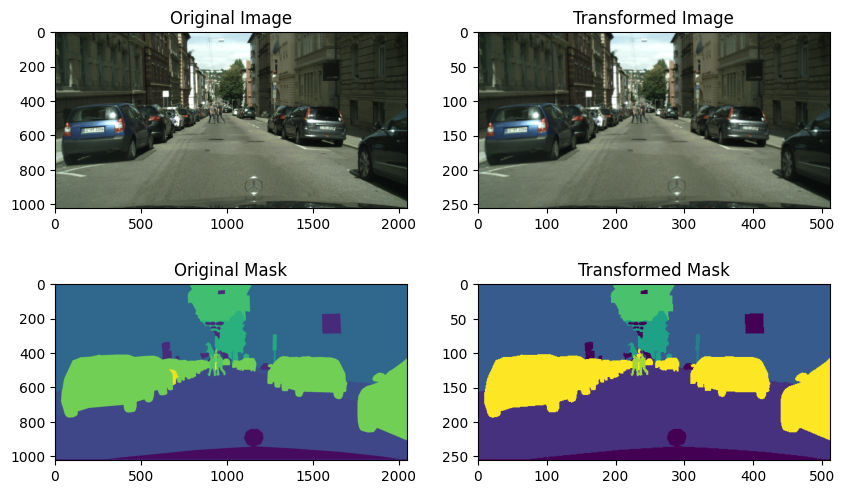

In [46]:
# Display the original and transformed images
fig, ax = plt.subplots(2, 2, figsize=(10, 6))
ax[0, 0].imshow(plt.imread(img_path))
ax[0, 0].set_title("Original Image")
ax[0, 1].imshow(img)
ax[0, 1].set_title("Transformed Image")
ax[1, 0].imshow(plt.imread(mask_path))
ax[1, 0].set_title("Original Mask")
ax[1, 1].imshow(mask)
ax[1, 1].set_title("Transformed Mask")
plt.show()

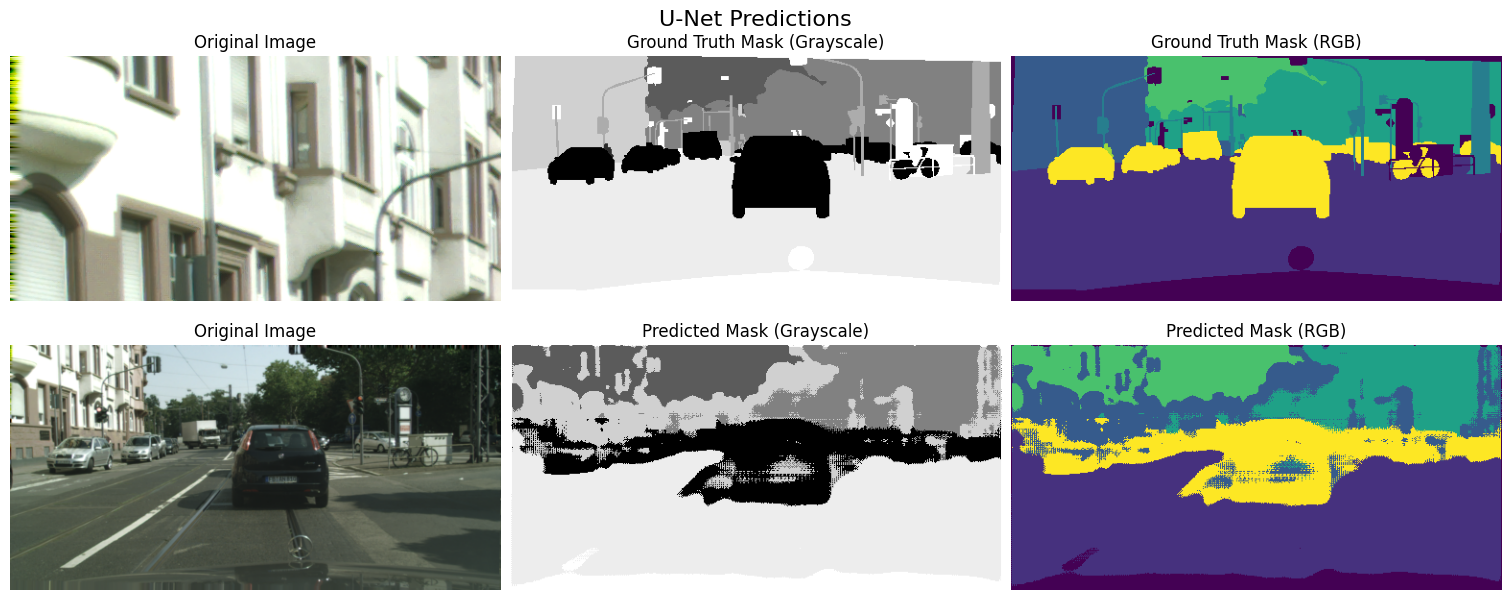

In [53]:
# Figure initialization
fig = plt.figure(layout="constrained", figsize=(15, 6))
fig.suptitle("U-Net Predictions", fontsize=16)
# Subfigures initialization
subfigs = fig.subfigures(2, 1, wspace=0.07)
axsTop = subfigs[0].subplots(1, 3, sharey=True, sharex=True)
axsBottom = subfigs[1].subplots(1, 3, sharey=True, sharex=True)
for i, ax in enumerate(axsTop):
    if i == 0:
        ax.imshow(plt.imread(img_path))
        ax.set_title("Original Image")
    elif i == 1:
        ax.imshow(mask, cmap="Greys")
        ax.set_title("Ground Truth Mask (Grayscale)")
    else:
        ax.imshow(mask)
        ax.set_title("Ground Truth Mask (RGB)")
    ax.axis("off")
for i, ax in enumerate(axsBottom):
    if i == 0:
        ax.imshow(img)
        ax.set_title("Original Image")
    elif i == 1:
        ax.imshow(preds_mask, cmap="Greys")
        ax.set_title("Predicted Mask (Grayscale)")
    else:
        ax.imshow(preds_mask)
        ax.set_title("Predicted Mask (RGB)")
    ax.axis("off")
plt.show()

In [20]:
# Pick a color palette for RGB labels with 7 colors (void is ignored)
sns.color_palette("tab10", 7)


[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902)]